In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from transformers import GPT2LMHeadModel

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained('gpt2')      # 124M parameters
sd_hf = model_hf.state_dict()


for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [3]:
sd_hf['transformer.wte.weight']

tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]])

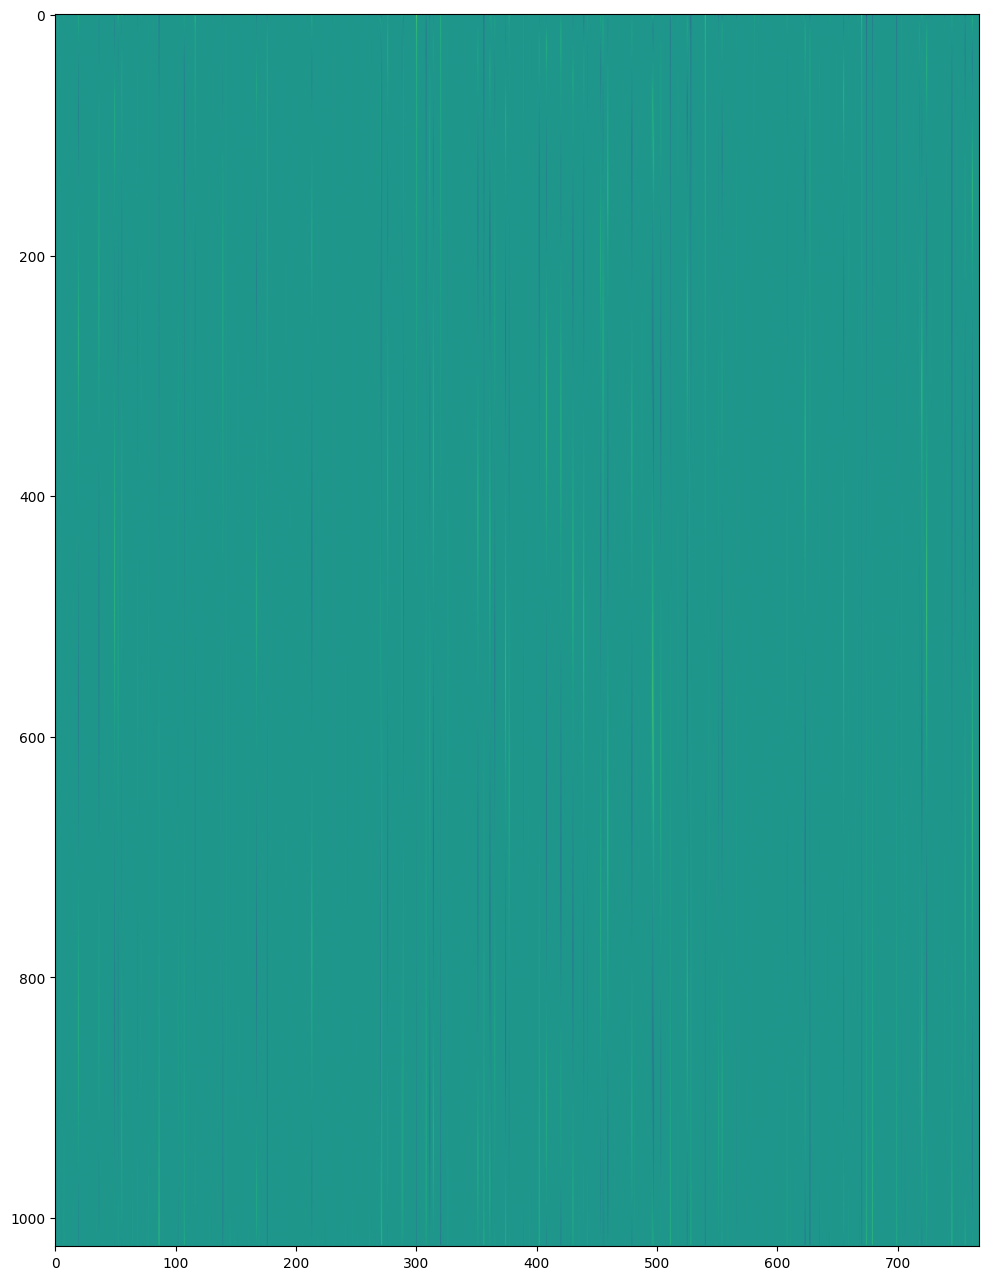

In [4]:
plt.figure(figsize=(16, 16))
plt.imshow(sd_hf['transformer.wpe.weight']);

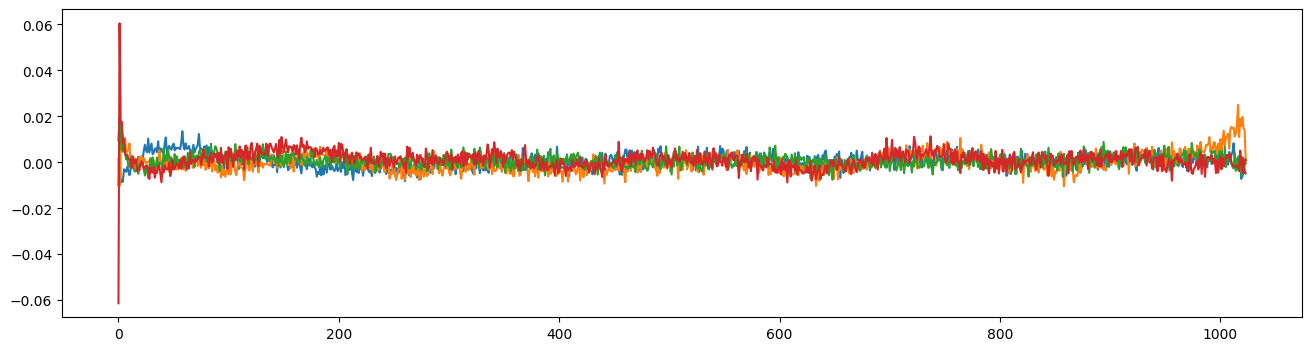

In [5]:
plt.figure(figsize=(16, 4))
plt.plot(sd_hf['transformer.wpe.weight'][:, torch.randint(0, sd_hf['transformer.wpe.weight'].shape[-1], (4, ))]);

In [6]:
sd_hf['lm_head.weight']

tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]])

In [7]:
from transformers import pipeline, set_seed

set_seed(2147483647)
generator = pipeline('text-generation', model='gpt2')
generator('hello, world', max_length=32, num_return_sequences=8)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'hello, world wide news, and our European coverage on global affairs. Sign up for the free BND Analysis newsletter here.\n\nRead or Share this story'},
 {'generated_text': 'hello, world.\n\nIn the world of media writing, the concept of "convenience media" is not really to be dissociated from a more'},
 {'generated_text': 'hello, world-famous rock band whose main theme, "Rock the World," is about the power of love. The group began playing rock shows as young boys'},
 {'generated_text': "hello, world's second largest company of solar cells, has announced the launch of its solar panels and mirrors, the first for the German company. As the first"},
 {'generated_text': "hello, world's most popular TV show, the game's main antagonist has a plan to kill the team's leader and take full control of Overwatch.\n\n"},
 {'generated_text': 'hello, world #1 in rankings\n\nTunisia 0:00 8.0 3.7\n\nRBI_COALITION_P'},
 {'generated_text': "hello, world, or any other country. If you're 

In [8]:
# let's instead sample manually
import torch
import torch.nn as nn
import torch.nn.functional as F

max_length = 24
model_type = 'gpt2'
num_return_sequences = 8
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

model = GPT2LMHeadModel.from_pretrained(model_type)         # 124M parameters

model.eval()
model.to(device)

# prefix tokens
import tiktoken
enc = tiktoken.get_encoding(model_type)
tokens = enc.encode('hello, world')                
tokens = torch.tensor(tokens, dtype=torch.long)                 # (T, )
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)    # (num_return_sequences, T)
x = tokens.to(device)

# generate
torch.manual_seed(2147483647)
torch.mps.manual_seed(2147483647)

while x.size(1) < 24:
    # forward the model to get logits
    with torch.no_grad():
        logits = model(x)[0]                                    # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :]                               # (B, vocab_size
        # get the probabilites
        probs = F.softmax(logits, dim=-1)
        # top-50 sampling (Hugging Face pipeline default)
        # topk_probs here becomes (num_return_sequences, k), topk_indices here becomes (num_return_sequences, k)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilites
        ix = torch.multinomial(topk_probs, 1)                   # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix)               # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

# print the generated text
for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print('>', decoded, '...\n')

> hello, world famous. I'm sure you remember the song "My Good Old Days," which goes like this: " ...

> hello, world)

2 1/3 minutes

Ingredients

1 whole banana, peeled and cut into ...

> hello, world's largest island, has been the subject of intense criticism after a Chinese vessel sank off the coast of Taiwan ...

> hello, world of tech - and what we can expect in 2017:

The rise of social networks has put internet ...

> hello, world: The world of Bitcoin — it's a global, international decentralized online retail marketplace — is being attacked. ...

> hello, world leader in health and wellness.

A small batch of vitamins, minerals and folic acid can be ...

> hello, world's largest and largest city." "He's trying to make sure it goes away. There are so many ...

> hello, world's top leader in artificial intelligence. For instance, he'll use machine learning to learn from real human error ...

